In [1]:
from segment2d import *
import numpy as np
import csv
from matplotlib import pyplot as plt
from ipywidgets import interact
# visualize the image and mask in z ax is using interact, image and mask are in one slice
import SimpleITK as sitk
import scipy.ndimage as ndimage
from metrics_segmentation import hd
import pydicom as dicom
from natsort import natsorted
import nrrd
from ipywidgets import interact

In [63]:
len(glob.glob("Tables/*"))

73

In [5]:
data_path = {"image": [], "mask": []}
for folder in natsorted(glob.glob("Tables/*")):
    image_paths = glob.glob(folder + "/*[!seg].nrrd")
    mask_paths = glob.glob(folder + "/*seg.nrrd")
    for i in range(len(image_paths)):
        image = nrrd.read(image_paths[i])[0]
        mask = nrrd.read(mask_paths[i])[0]
        if image.shape != mask.shape:
            print(image_paths[i])
        data_path["image"].append(image_paths[i])
        data_path["mask"].append(mask_paths[i])

In [3]:
def preprocess_data(image_path):
    data = {}
    image = nrrd.read(image_path)[0]
    image = min_max_normalize(image)

    padded_image, crop_index, padded_index = pad_background(image, dim2pad=cfg.DATA.DIM2PAD)
    # padded_mask = pad_background_with_index(mask, crop_index, padded_index, dim2pad=cfg.DATA.DIM2PAD)
    data["crop_index"] = crop_index
    data["padded_index"] = padded_index
    data["original_shape"] = image.shape
    batch_images = []
    for i in range(padded_image.shape[-1]):
        slice_inputs = padded_image[..., i : i + 1]  # shape (224, 224, 1)
        slices_image = torch.from_numpy(slice_inputs.transpose(-1, 0, 1))  # shape (1, 224, 224)
        batch_images.append(slices_image)

    batch_images = torch.stack(batch_images).float()  # shape (9,1, 224, 224)
    data["image"] = batch_images
    return data


def predict_data(data, segmenter):
    probability_output = segmenter.predict_patches(data["image"])  # shape (n, 5, 128, 128)
    seg = np.argmax(probability_output, axis=1).transpose(1, 2, 0)  # shape (128, 128, n)
    seg = remove_small_elements(seg, min_size_remove=600)
    seg[seg == 3] = 2
    seg[seg == 4] = 2
    seg[seg == 1] = 0
    seg[seg == 2] = 1
    invert_seg = invert_padding(data["original_shape"], seg, data["crop_index"], data["padded_index"])
    return invert_seg
task = "train_full"
cfg.DATA.CLASS_WEIGHT = [0.1, 2, 2, 17, 140]
num_classes = 5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCDenseNet(in_channels=cfg.DATA.INDIM_MODEL, n_classes=num_classes)
segmenter = Segmenter(
    model,
    cfg.DATA.CLASS_WEIGHT,
    5,
    0.001,
    0.5,
    50,
)
checkpoint = "./weights_train_full/last.ckpt"
segmenter = Segmenter.load_from_checkpoint(
    checkpoint_path=checkpoint,
    model=model,
    class_weight=cfg.DATA.CLASS_WEIGHT,
    num_classes=num_classes,
    learning_rate=0.001,
    factor_lr=0.5,
    patience_lr=50,
)
segmenter = segmenter.to(device)

In [7]:
dice_scores = {"dice_myocardium": []}
list_test_subject = data_path["image"]
mask_test_subject = data_path["mask"]

for idx in range(len(list_test_subject)):
    folder = list_test_subject[idx].split("/")[-2]
    data = preprocess_data(list_test_subject[idx])
    # padded_image, crop_index, padded_index = pad_background(test_image, dim2pad=cfg.DATA.DIM2PAD)
    seg = predict_data(data, segmenter).astype(np.uint8)
    mask_image = nrrd.read(mask_test_subject[idx])[0]
    dice_myo = dice_volume(mask_image, seg, class_index=1)
    dice_scores["dice_myocardium"].append(dice_myo)
    print(f"folder: {folder}, myo: {dice_myo:0.4f}")

folder: 1 - PGF, myo: 0.7881
folder: 2- FPA, myo: 0.7636
folder: 3 - DHD, myo: 0.7013
folder: 4 - HDR, myo: 0.7416
folder: 5 - AAS, myo: 0.7837
folder: 7 - ASP, myo: 0.7383
folder: 10 - CMV, myo: 0.6516
folder: 11 - MTB, myo: 0.6421
folder: 12 - FLC, myo: 0.7468
folder: 13 - NPA, myo: 0.7047
folder: 14 - HNS, myo: 0.7822
folder: 16 - ACR, myo: 0.7260
folder: 17 - MLF, myo: 0.7345
folder: 18 - ALM, myo: 0.8200
folder: 19-JRG, myo: 0.6566
folder: 21 - JCS, myo: 0.6927
folder: 22 - LAP, myo: 0.7164
folder: 23-AGL, myo: 0.7491
folder: 24-AFP, myo: 0.6418
folder: 27 - AEO, myo: 0.6836
folder: 28 - CAC, myo: 0.6663
folder: 29-JGQ, myo: 0.7442
folder: 31 - GSR, myo: 0.7810
folder: 32 - LJC, myo: 0.7793
folder: 32 - LJC, myo: 0.7424
folder: 33_Manuel David Mira, myo: 0.6798
folder: 34 - JDR, myo: 0.6661
folder: 36_MCD, myo: 0.6586
folder: 37 - MCS, myo: 0.7373
folder: 38_AJF, myo: 0.6816
folder: 39 - PSJ, myo: 0.7393
folder: 42_PCF, myo: 0.5328
folder: 43 - NFC, myo: 0.6806
folder: 44-DCT, myo

In [8]:
np.mean(dice_scores["dice_myocardium"])

0.7186616940043374

In [18]:
list_test_subject[idx], mask_test_subject[idx]

('Tables/Patient1/42 de_trufi_high-res_PSIR EC_PSIR_1.nrrd',
 'Tables/Patient1/Myocardium.seg.nrrd')

In [16]:
list_test_subject = data_path["image"]
mask_test_subject = data_path["mask"]
idx = -2
data = preprocess_data(list_test_subject[idx])
seg = predict_data(data, segmenter).astype(np.uint8)
test_image = nrrd.read(list_test_subject[idx])[0]
padded_image, crop_index, padded_index = pad_background(test_image, dim2pad=cfg.DATA.DIM2PAD)
seg_padded = pad_background_with_index(seg, crop_index, padded_index, dim2pad=cfg.DATA.DIM2PAD)
mask = nrrd.read(mask_test_subject[idx])[0]
mask_padded = pad_background_with_index(mask, crop_index, padded_index, dim2pad=cfg.DATA.DIM2PAD)

In [17]:
def plot_image_mask_z(image, mask, z, prediction=None):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(image[..., z], cmap="gray")
    ax[0].set_title("Image")
    ax[1].imshow(image[..., z], cmap="gray", alpha=0.8)
    ax[1].set_title("Ground Truth")
    # set color for jet cmap, pixel value 1 is red, 2 is green, 3 is blue, 4 is yellow
    ax[1].imshow(mask[..., z], cmap="jet", alpha=0.3, vmin=0, vmax=2)

    if prediction is not None:
        ax[2].imshow(image[..., z], cmap="gray", alpha=0.8)
        ax[2].set_title("Prediction")
        ax[2].imshow(prediction[..., z], cmap="jet", alpha=0.3, vmin=0, vmax=2)
    # off axis
    ax[0].axis("off")
    ax[1].axis("off")
    ax[2].axis("off")
    plt.show()
interact(lambda z: plot_image_mask_z(padded_image, mask_padded, z, seg_padded), z=(0, test_image.shape[-1] - 1))

interactive(children=(IntSlider(value=7, description='z', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.<lambda>(z)>

interactive(children=(IntSlider(value=3, description='z', max=7), Output()), _dom_classes=('widget-interact',)…

<function __main__.<lambda>(z)>

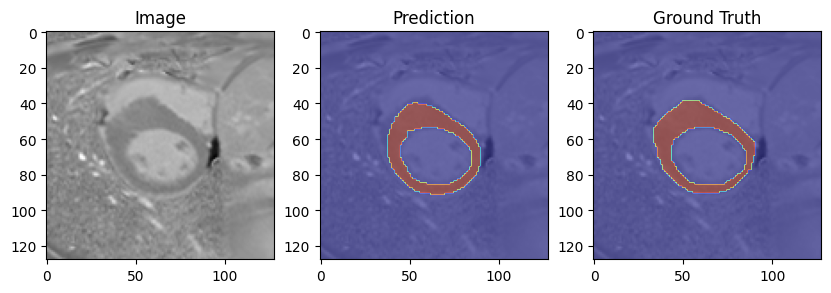

In [148]:
idx = 3
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(padded_image[..., idx], cmap="gray")
ax[0].set_title("Image")
ax[1].set_title("Prediction")
ax[2].set_title("Ground Truth")
ax[1].imshow(padded_image[..., idx], cmap="gray", alpha=0.7)
ax[1].imshow(seg_padded[..., idx], cmap="jet", alpha=0.5)
ax[2].imshow(padded_image[..., idx], cmap="gray", alpha=0.7)
ax[2].imshow(mask_padded[..., idx], cmap="jet", alpha=0.5)
plt.show()